<a href="https://colab.research.google.com/github/SiLiKhon/IMLWorkshop/blob/master/pytorch_ard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational dropout sparsification on PyTorch

The technique is described in this paper: [arxiv:1701.05369](https://arxiv.org/abs/1701.05369)

This approach was implemented for fully connected and convolutional layers in PyTorch: https://github.com/HolyBayes/pytorch_ard

The discovered approach helps to train both convolutional and dense deep sparsified models without significant loss of quality. Additive Noise Reparameterization
and the Local Reparameterization Trick discovered in the paper helps to eliminate weights prior's restrictions (<a href="https://www.codecogs.com/eqnedit.php?latex=\alpha\leq&space;1" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha\leq&space;1" title="\alpha\leq 1" /></a>) and achieve Automatic Relevance Determination (ARD) effect on (typically most) network's parameters. According to the original paper, authors reduced the number of parameters up to 280 times on LeNet architectures and up to 68 times on VGG-like networks with a negligible decrease of accuracy. 

This technique helps to significantly reduce overfitting and helps to not worry about model's complexity - all redundant parameters will be dropped automatically. Moreover, you can achieve any degree of regularization variating regularization factor tradeoff.

## Prerequisites

Let's start by installing this linbrary:

In [0]:
pip install git+https://github.com/HolyBayes/pytorch_ard

## Setup

Some imports:

In [0]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data
import torch_ard as nn_ard
from torch import nn
from torchvision import datasets
from torchvision import transforms

Let's define some useful variables:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path_baseline = 'models/baseline.pt'
model_path_sparse = 'models/sparse.pt'
batch_size = 128

print(device)

cuda


This example is based on the MNIST dataset. Let's download it and use `torch.utils.data.DataLoader` to automatically iterate over minibatches:

In [0]:
trainset = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

testset = datasets.MNIST(
    './data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1024, shuffle=True
)

It's always a good idea to visualize the data you're working with :)

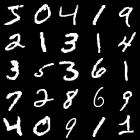

In [5]:
transforms.ToPILImage()(
    torch.transpose(
        trainset.data[:25].view(5, 5, 28, 28),
        1, 2
    ).reshape(140, 140)
)

Here's a little utility class that will help us keep track of the losses and other metrics:

In [0]:
from IPython.display import clear_output

class Logger:
  def __init__(self):
    self.train_loss_batch = []
    self.train_loss_epoch = []
    self.train_metrics_batch = {}
    self.test_loss_batch = []
    self.test_loss_epoch = []
    self.test_metrics_batch = {}
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    self.epoch_counter = 0

  def fill_train(self, loss, **other_metrics):
    self.train_loss_batch.append(loss)
    self.train_batches_per_epoch += 1
    for k, v in other_metrics.items():
      self.train_metrics_batch.setdefault(k, []).append(v)

  def fill_test(self, loss, **other_metrics):
    self.test_loss_batch.append(loss)
    self.test_batches_per_epoch += 1
    for k, v in other_metrics.items():
      self.test_metrics_batch.setdefault(k, []).append(v)

  def finish_epoch(self):
    self.train_loss_epoch.append(np.mean(
        self.train_loss_batch[-self.train_batches_per_epoch:]
    ))
    self.test_loss_epoch.append(np.mean(
        self.test_loss_batch[-self.test_batches_per_epoch:]
    ))
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    
    clear_output()
  
    print("epoch #{} \t train_loss: {:.8} \t test_loss: {:.8}".format(
              self.epoch_counter,
              self.train_loss_epoch[-1],
              self.test_loss_epoch [-1]
          ))
    for k, v in self.train_metrics_batch.items():
      print("           \t train_{}: {:.4} \t test_{} {:.4}".format(
                k, np.mean(v),
                k, np.mean(self.test_metrics_batch[k])
            ))
    self.train_metrics_batch = {}
    self.test_metrics_batch = {}
    
    self.epoch_counter += 1

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.train_loss_batch, label='train loss')
    plt.xlabel('# batch iteration')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.train_loss_epoch, label='average train loss')
    plt.plot(self.test_loss_epoch , label='average test loss' )
    plt.legend()
    plt.xlabel('# epoch')
    plt.ylabel('loss')
    plt.show();

We'll also need a reshaping layer to apply a fully-connected layer after the convolutions:

In [0]:
class Reshape(nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(x.shape[0], *self.shape)

## Baseline model

### Model definition

Our baseline model (without sparsification) will consist of 2 convolutional+maxpool layers and one hidden fully-connected layer.

> *Note that to avoid overfitting here we need to use regular (Bernoulli distributed) dropout.*

In [0]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), # 1x28x28 -> 16x24x24
    nn.MaxPool2d(kernel_size=2), # -> 16x12x12
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # -> 32x8x8
    nn.MaxPool2d(kernel_size=2), # -> 32x4x4
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    Reshape(512),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=256, out_features=10)
).to(device)

for layer in model.children():
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))


loss_function = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

epoch #19 	 train_loss: 0.0097514375 	 test_loss: 0.021000598
           	 train_accuracy: 0.9967 	 test_accuracy 0.993


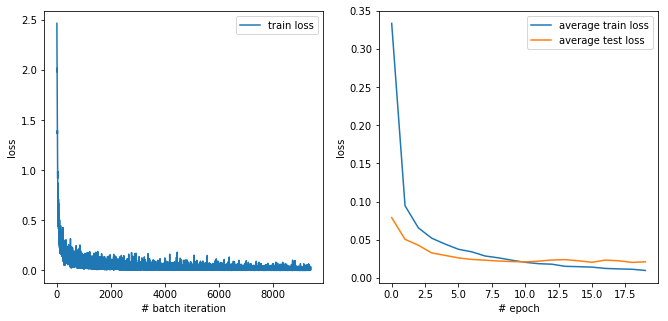

In [10]:
n_epochs = 20

logger = Logger()

for _ in range(n_epochs):
  model.train()
  for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)
    model.zero_grad()

    logits = model(inputs)
    loss = loss_function(logits, targets)
    
    accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())

    loss.backward()
    optimizer.step()
    
    logger.fill_train(loss.item(), accuracy=accuracy.item())
  
  model.eval()
  with torch.no_grad():
    for inputs, targets in testloader:
      inputs, targets = inputs.to(device), targets.to(device)
      logits = model(inputs)
      loss = loss_function(logits, targets)
      
      accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())
      
      logger.fill_test(loss.item(), accuracy=accuracy.item())

  logger.finish_epoch()
      

Let's save our model:

In [0]:
os.makedirs(os.path.dirname(model_path_baseline), exist_ok=True)
torch.save(model, model_path_baseline)

----------------

## Sparse model

### Model definition

Here we'll use the same architecture. The `torch_ard` library is implemented in such a way, that ARD layers have same interface as relevant layers from `torch.nn`, i.e. you can just do the following replacements:

  * `nn.Linear(*parameters)` $\rightarrow$ `nn_ard.LinearARD(*parameters)`
  * `nn.Conv2d(*parameters)` $\rightarrow$  `nn_ard.Conv2dARD(*parameters)`
  
Each weight of these layers is normally distributed and therefore is defined in terms of two parameters: $\mu$ and $\sigma^2$. During the training, sampling from these normal distributions happens at each forward pass. At evaluation, the network is sparsified by eliminating the weights with large $\sigma^2$ and all other weights are deterministically set to their $\mu$ values.

> *Note that we don't need dropout layers anymore - the regularisation is performed automatically!*

In [0]:
model = nn.Sequential(
    nn_ard.Conv2dARD(in_channels=1, out_channels=16, kernel_size=5), # 1x28x28 -> 16x24x24
    nn.MaxPool2d(kernel_size=2), # -> 16x12x12
    nn.ReLU(),
    
    nn_ard.Conv2dARD(in_channels=16, out_channels=32, kernel_size=5), # -> 32x8x8
    nn.MaxPool2d(kernel_size=2), # -> 32x4x4
    nn.ReLU(),
    
    Reshape(512),
    nn_ard.LinearARD(in_features=512, out_features=256),
    nn.ReLU(),
    nn_ard.LinearARD(in_features=256, out_features=10)
).to(device)

for layer in model.children():
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))

loss_function = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

epoch #29 	 train_loss: 0.036466258 	 test_loss: 0.030893128
           	 train_accuracy: 0.9887 	 test_accuracy 0.9905


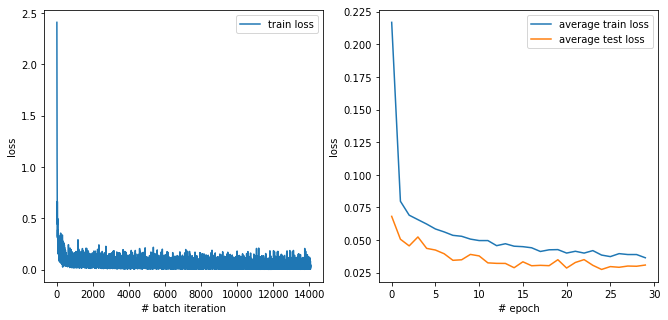

Sparsification ratio: 88.473%


In [13]:
n_epochs = 30
reg_param = 0.005 # This parameter controls automatic regularisation:
                  # the higher its value - the more sparse your network
                  # will get, possibly with the price of decrease in
                  # performance

logger = Logger()

for i_epoch in range(n_epochs):
  model.train()
  for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)
    model.zero_grad()

    logits = model(inputs)
    loss = loss_function(logits, targets)
    
    accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())

    # Here's how the regularizer is added to the loss:
    total_loss = loss + reg_param * nn_ard.get_ard_reg(model) * targets.shape[0] / len(trainset)

    total_loss.backward()
    optimizer.step()
    
    logger.fill_train(loss.item(), accuracy=accuracy.item())
  
  model.eval()
  with torch.no_grad():
    for inputs, targets in testloader:
      inputs, targets = inputs.to(device), targets.to(device)
      logits = model(inputs)
      loss = loss_function(logits, targets)
      
      accuracy = torch.mean((torch.argmax(logits, dim=1) == targets).float())
      
      logger.fill_test(loss.item(), accuracy=accuracy.item())

  logger.finish_epoch()
  
  # You can check the sparsity of your model using nn_ard.get_dropped_params_ratio(...).
  # This function returns the fraction of removed weights.
  print('Sparsification ratio: {:.3f}%'.format(100. * nn_ard.get_dropped_params_ratio(model)))

Saving the model:

In [0]:
torch.save(model, model_path_sparse)